Scope:

This branch should implement torch functionality in expsolve. 

Once investigations are done, the derivative part needs to go in fourier and splittings, for e.g., to make torch compatible derivatives, and this file should be deleted. 

Torch compatible applications should be in their own specific branches and not included here. 

In [1]:
import numpy as np
import matplotlib.pylab as plt

import expsolve as es
import expsolve.splittings.classical as split
import expsolve.fourier as ex

import torch
from torch import exp, sin, abs, real, imag, pi, diag
from torch.linalg import matrix_exp
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from IPython import display
from torch.optim.lr_scheduler import StepLR

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Hamiltonian Identification

### True Hamiltonian

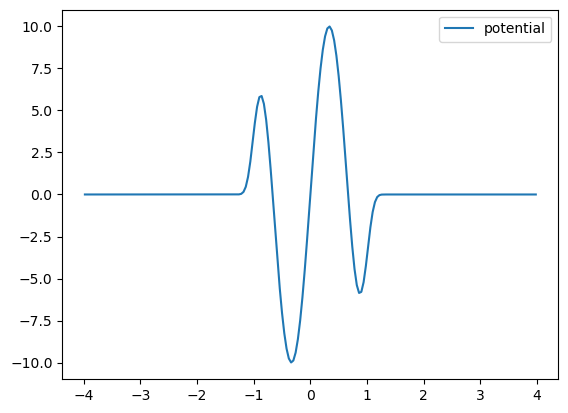

In [4]:
n = 200
L = 4
xr = [-L, L]
X = ex.grid1d(n, xr)                    # plot versions
V = 10.*exp(-X**8/1)*sin(1.5*pi*X)      # plot versions

x = X.to(device)                        # computational versions - possibly on GPU
v = V.to(device)                        # computational versions - possibly on GPU

plt.plot(X, V)

plt.legend(['potential'])
plt.show()

### Solvers

In [5]:
eLu = lambda t, tauV, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda V: lambda t, tauL, h, c, u: exp(-1j*c*h*V)*u

strangalpha, strangbeta = split.symmetric([],[])
strangstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, strangalpha, strangbeta)

a = torch.tensor([0.0792036964311957, 0.353172906049774, -0.0420650803577195], dtype=torch.float64)
b = torch.tensor([0.209515106613362, -0.143851773179818], dtype=torch.float64)
blanesmoanalpha, blanesmoanbeta = split.symmetric(a,b)
#blanesmoanalpha.to(device)
#blanesmoanbeta.to(device)
blanesmoanstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, blanesmoanalpha, blanesmoanbeta)

strangsolver = lambda V, u, T, N: es.evolve(u, es.timegrid(T, N), strangstep(V) )[0]
blanesmoansolver = lambda V, u, T, N: es.evolve(u, es.timegrid(T, N), blanesmoanstep(V) )[0]

## Dataset

Randomly generated Gaussian Wave Packets

In [6]:
def ugen(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0 = np.random.normal(loc=0, scale=sw0)

    u = exp(-(x-x0)**2/(2*var))*exp(1j*pi*w0*(x-x0))    
    u = ex.normalize(u, xr)
    return u

In [10]:
# Define your custom dataset class
class GaussianWavefunctions(Dataset):
    def __init__(self, sx0, svar, sw0, T, N, solver):
        self.sx0 = sx0
        self.svar = svar
        self.sw0 = sw0
        self.T = T
        self.N = N
        self.solver = solver

    def __len__(self):
        return 10000

    def __getitem__(self, index):
        u0 = ugen(self.sx0, self.svar, self.sw0)
        uT = self.solver(v, u0, self.T, self.N)
        return u0, uT

dataset = GaussianWavefunctions(sx0 = 1.0, svar = 0.3, sw0 = 1.5, T = 0.1, N = 20, solver=blanesmoansolver)
batch_size = 10
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataiterator = iter(dataloader)

In [11]:
def batchplot(ubatch):
    plt.figure(figsize=(8, 4))
    plt.ylim(-4,4)

    plt.plot(X, V/2)
    for u in ubatch:
        plt.plot(X, real(u.cpu()))      # if GPU is enabled, ubatch should be on GPU 
        plt.plot(X, imag(u.cpu()))

    plt.show()

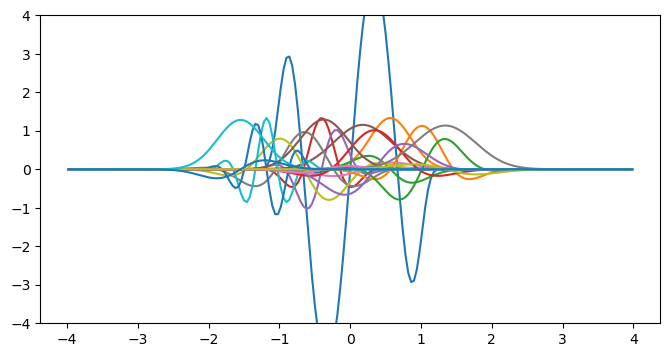

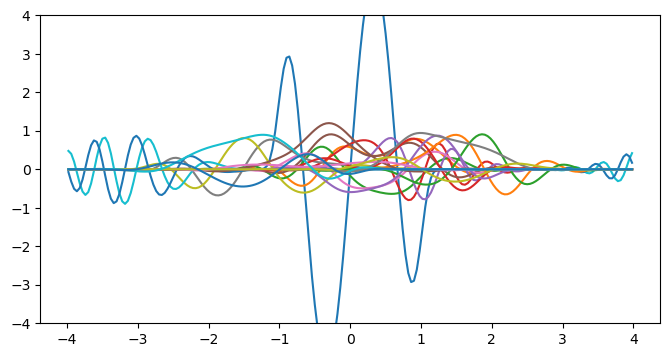

In [12]:
u0, uT = next(dataiterator)

batchplot(u0)
batchplot(uT)

# Neural Network Model

In [13]:
class VNN(nn.Module):

    def __init__(self, x, T, N, solver):
        super(VNN, self).__init__()
        self.T = T
        self.N = N
        self.solver = solver
        self.x = x.unsqueeze(1)
        self.n = x.shape[0]

        self.NN = nn.Sequential(
            nn.Linear(1, 20),   # Fully connected layer 1 with 1 input and 32 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 1)    # Fully connected layer 3 with 16 input neurons and 1 output neuron
            )

        self.NN = self.NN.double()    # double precision

    def _potential(self):
        return self.NN(self.x).reshape([self.n])

    # for non-training needs
    def potential(self):
        with torch.no_grad():
            pot = self._potential().cpu()
        return pot

    def forward(self, u0):
        uT = self.solver(self._potential(), u0, self.T, self.N)
        return uT

        
model = VNN(x, T=0.1, N=20, solver=strangsolver).to(device)

Checking out the current potential inside the VNN

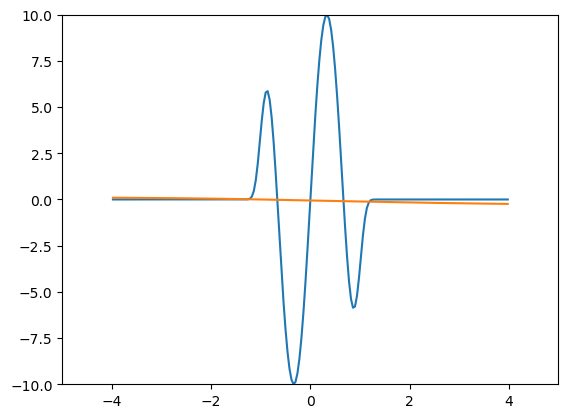

In [14]:
plt.plot(X, V)
plt.plot(X, model.potential())
plt.xlim(-5,5)
plt.ylim(-10,10)

plt.show()

Solving till T under the current potential of the VNN

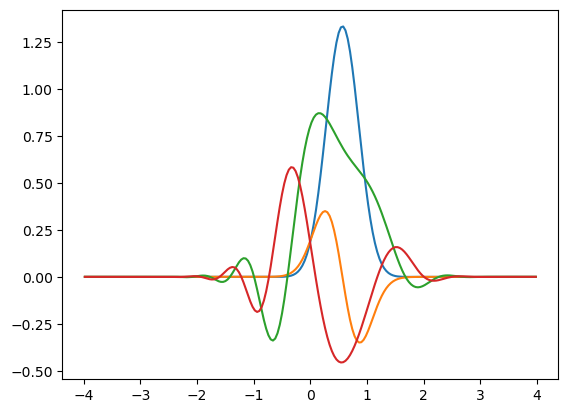

In [15]:
u0c = u0[0].cpu()
uTc = model(u0[0]).detach().cpu()

plt.plot(X, real(u0c))
plt.plot(X, imag(u0c))
plt.plot(X, real(uTc))
plt.plot(X, imag(uTc))
plt.show()

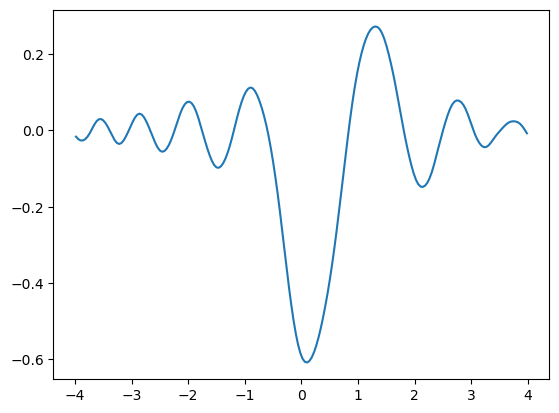

In [17]:
plt.plot(X, real(strangsolver(v, u0[0], 0.2, 20)-strangsolver(0*v, u0[0], 0.2, 20)).cpu() )    # what happens when we get V incorrect
plt.show()

Batch processing

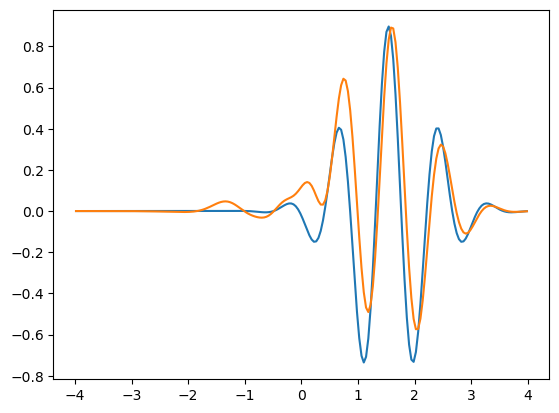

tensor(0.0060, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)

In [18]:
u0, uTref = next(dataiterator)
uTpred = model(u0)

plt.plot(X, real(u0[0,:].detach().cpu()))
plt.plot(X, real(uTpred[0,:].detach().cpu()))
plt.show()

dx = x[1]-x[0]
criterion = nn.MSELoss()
loss = dx * (criterion(real(uTpred), real(uTref)) + criterion(imag(uTpred), imag(uTref)))
loss

The issue is that the model is not batch parallelized. This needs to be changed at expsolve level.

## CLEAN/DEL

In [210]:
nn.parallel.parallel_apply

<function torch.nn.parallel.parallel_apply.parallel_apply(modules, inputs, kwargs_tup=None, devices=None)>

In [236]:
# Define your custom function that operates on each data point
def custom_function(x, fixed_param):
    # Example: Compute the square of the input tensor x and add the fixed parameter
    return x * x + fixed_param

# Wrap the custom function with parallel_apply (even for a single GPU)
def data_parallel_apply(custom_function, data, fixed_param, device_id):
    replicas = [custom_function for _ in range(device_id + 1)]
    outputs = nn.parallel.parallel_apply(replicas, data, device=[device_id]) #, device_ids=[device_id])
    return outputs

# Prepare your input data (example)
x_values = [0.1, 0.5, 1.0, 1.5]
x_tensor = torch.tensor(x_values, dtype=torch.float32).unsqueeze(1)

# Move the input data to the GPU
x_tensor = x_tensor.to(device)

# Specify the fixed parameter and the GPU to be used for parallel processing
fixed_param = 10
device_id = 0  # Only one GPU is available (GPU 0)

# Apply the custom function with the fixed parameter in a data parallel manner
output_tensors = data_parallel_apply(custom_function, [x_tensor], fixed_param, device_id)

# Combine the results if necessary (e.g., if you have multiple replicas for a single GPU)
output_tensor = torch.cat(output_tensors)

# Print the results
print("Input Data:")
print(x_tensor)
print("Output Data:")
print(output_tensor)

TypeError: parallel_apply() got an unexpected keyword argument 'device'

In [126]:
torch.nn.parallel.parallel_apply

<function torch.nn.parallel.parallel_apply.parallel_apply(modules, inputs, kwargs_tup=None, devices=None)>

# Loss

In [19]:
def lossfn(V, u0batch, uTbatch, solver, T, N):
    dx = X[1]-X[0]
    nbatch = u0batch.shape[0]

    loss = torch.tensor(0., dtype=torch.float64).to(device)

    for u0, uTref in zip(u0batch, uTbatch):
        uT = solver(V, u0, T, N)
        # plt.plot(X, real(u0.detach().cpu()))
        # plt.plot(X, real(uT.detach().cpu()))
        # plt.show()
        loss += torch.norm(uT - uTref)**2
    
    loss = dx * loss/nbatch
    return loss

lossfn(model._potential(), u0, uT, solver=strangsolver, T=0.1, N=20)

tensor(1.6478, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

At step 299, loss is 0.000962179999225506


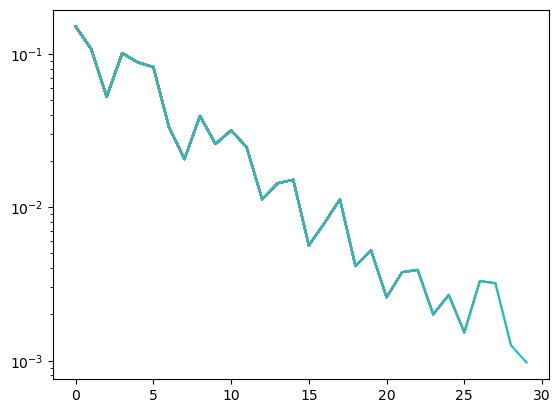

In [21]:
%matplotlib inline

# Create an instance of the SimpleNN model
model = VNN(x, T=0.1, N=20, solver=blanesmoansolver).to(device)
nn.DataParallel(model).to(device)

nbatch=10
dataloader = DataLoader(dataset, batch_size=nbatch, shuffle=True)
dataiterator = iter(dataloader)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #, dtype=torch.double)
num_steps = 300

trerror = []

dx = x[1]-x[0]

for step in range(num_steps):
    # Compute the loss

    u0batch, uTrefbatch = next(dataiterator)
    #uTpred = model(u0)

    loss = lossfn(model._potential(), u0batch, uTrefbatch, solver=blanesmoansolver, T=0.1, N=20)

    # criterion = nn.MSELoss()

    # loss = torch.tensor(0., dtype=torch.float64).to(device)
    # for u0, uTref in zip(u0batch, uTrefbatch):
    #     uTpred = model(u0)      # currently the model is not batch parallel. This needs to be fixed deep in expsolve.
    #     loss += criterion(real(uTpred), real(uTref)) + criterion(imag(uTpred), imag(uTref))

    # loss = loss/nbatch

    # print(f'At step {step}, loss is {loss}')

    # Zero the gradients to prevent accumulation
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    if np.mod(step, 10)==0:
        trerror.append(loss.detach().cpu().numpy())        
        plt.semilogy(trerror)
        display.display(plt.gcf())
        display.clear_output(wait=True)


    # Update parameters using the gradients
    optimizer.step()


print(f'At step {step}, loss is {loss}')

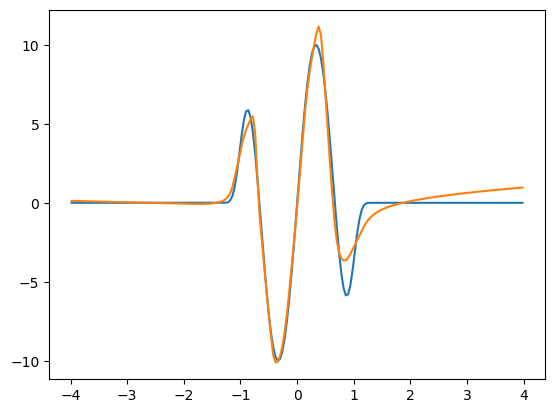

In [22]:
plt.plot(X, V)
plt.plot(X, model.potential())
plt.show()

# Optimal Control